<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/blob/master/module3-model-interpretation/assignment_Model_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Tree Ensembles_ 

# Model Interpretation

### Objectives
- Partial Dependence Plots
- Shapley Values


### Pre-reads
1. Kaggle / Dan Becker: Machine Learning Explainability
  - https://www.kaggle.com/dansbecker/partial-plots
  - https://www.kaggle.com/dansbecker/shap-values
2. Christoph Molnar: Interpretable Machine Learning
  - https://christophm.github.io/interpretable-ml-book/pdp.html
  - https://christophm.github.io/interpretable-ml-book/shapley.html 


### Librarires
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [shap](https://github.com/slundberg/shap): `conda install -c conda-forge shap` / `pip install shap`

  
### Types of explanations

#### Global explanation: all features in relation to each other
- Feature Importances (mean decrease impurity)
- Permutation Importances
- Drop-Column Importances

#### Global explanation: individual feature in relation to target
- Partial Dependence plots

#### Individual prediction explanation
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

# Titanic

In [0]:
%matplotlib inline
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def load_titanic():
    df = sns.load_dataset('titanic')
    df['age'] = df['age'].fillna(df['age'].mean())
    df['class'] = df['class'].map({'First': 1, 'Second': 2, 'Third': 3})
    df['female'] = df['sex'] == 'female'
    X = df[['age', 'class', 'fare', 'female']]
    y = df['survived']
    return X, y

X, y = load_titanic()

#### Naive majority calss baseline

In [2]:
y.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: survived, dtype: float64

#### Logistic Regression

In [3]:
lr = LogisticRegression(solver='lbfgs')
cross_val_score(lr, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.7877095 , 0.78212291, 0.78651685, 0.7752809 , 0.80225989])

In [4]:
lr.fit(X, y)
pd.Series(lr.coef_[0], X.columns)

age      -0.032595
class    -1.112937
fare      0.000805
female    2.512794
dtype: float64

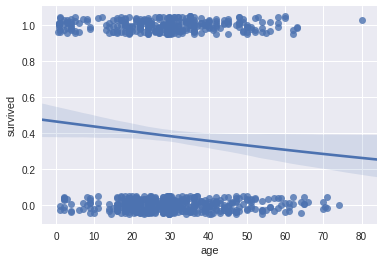

In [5]:
sns.regplot(x=X['age'], y=y, logistic=True, y_jitter=.05);

#### Gradient Boosting

In [6]:
gb = GradientBoostingClassifier()
cross_val_score(gb, X, y, scoring='accuracy', cv=5, n_jobs=-1)

array([0.80446927, 0.82681564, 0.85393258, 0.83146067, 0.84745763])

In [7]:
gb.fit(X, y)
pd.Series(gb.feature_importances_, X.columns)

age       0.131270
class     0.173907
fare      0.199515
female    0.495308
dtype: float64

In [9]:
!pip install pdpbox

    100% |████████████████████████████████| 57.7MB 409kB/s 
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


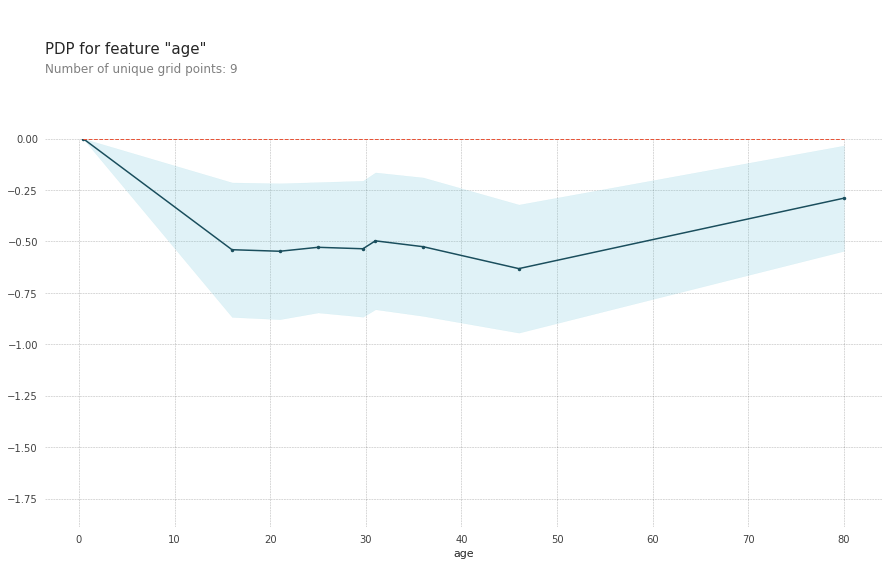

In [10]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='age'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

#### Compare Predictions

In [11]:
from sklearn.model_selection import cross_val_predict

y_pred_lr = cross_val_predict(lr, X, y, cv=5, n_jobs=-1)
y_pred_gb = cross_val_predict(gb, X, y, cv=5, n_jobs=-1)

preds = pd.DataFrame({'true': y, 'lr': y_pred_lr, 'gb': y_pred_gb})
              
gb_right = preds['gb'] == preds['true']
lr_wrong = preds['lr'] != preds['true']

len(preds[gb_right & lr_wrong]) / len(preds)

0.08417508417508418

In [12]:
preds[gb_right & lr_wrong].head()

,gb,lr,true
27,0,1,0
64,0,1,0
71,0,1,0
74,1,0,1
78,1,0,1


In [13]:
data_for_prediction = X.loc[27]

data_for_prediction

age          19
class         1
fare        263
female    False
Name: 27, dtype: object

#### Explain individual prediction

https://www.kaggle.com/dansbecker/shap-values

In [15]:
!pip install shap

    100% |████████████████████████████████| 225kB 7.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [16]:
import shap

# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# Lending Club

In [19]:
!pip install category_encoders

    100% |████████████████████████████████| 61kB 2.4MB/s 


In [0]:
import category_encoders as ce
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Load data from https://www.kaggle.com/c/ds1-tree-ensembles/data
train_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_features.csv"
label_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/train_labels.csv"
test_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/test_features.csv"
submission_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/sample_submission.csv"
LCDataDictionary_url="https://raw.githubusercontent.com/cocoisland/DS-Unit-4-Sprint-1-Tree-Ensembles/master/data/LCDataDictionary.xlsx"

X_train = pd.read_csv(train_url)
y_train = pd.read_csv(label_url)['charged_off']
X_test = pd.read_csv(test_url)
X_submission = pd.read_csv(submission_url)
X_Dict = pd.read_excel(LCDataDictionary_url)

def wrangle(X):
    X = X.copy()
    
    # Drop some columns
    X = X.drop(columns='id')  # id is random
    X = X.drop(columns=['member_id', 'url', 'desc'])  # All null
    X = X.drop(columns='title')  # Duplicative of purpose
    X = X.drop(columns='grade')  # Duplicative of sub_grade
    
    # Transform sub_grade from "A1" - "G5" to 1.1 - 7.5
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    
    X['sub_grade'] = X['sub_grade'].apply(wrangle_sub_grade)

    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
        
    # Transform earliest_cr_line to an integer: how many days it's been open
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = pd.Timestamp.today() - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days
    
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)
    
    # Drop categoricals with high cardinality
    X = X.drop(columns=['emp_title', 'zip_code'])
    
    # Transform features with many nulls to binary flags
    many_nulls = ['sec_app_mths_since_last_major_derog',
                  'sec_app_revol_util',
                  'sec_app_earliest_cr_line',
                  'sec_app_mort_acc',
                  'dti_joint',
                  'sec_app_collections_12_mths_ex_med',
                  'sec_app_chargeoff_within_12_mths',
                  'sec_app_num_rev_accts',
                  'sec_app_open_act_il',
                  'sec_app_open_acc',
                  'revol_bal_joint',
                  'annual_inc_joint',
                  'sec_app_inq_last_6mths',
                  'mths_since_last_record',
                  'mths_since_recent_bc_dlq',
                  'mths_since_last_major_derog',
                  'mths_since_recent_revol_delinq',
                  'mths_since_last_delinq',
                  'il_util',
                  'emp_length',
                  'mths_since_recent_inq',
                  'mo_sin_old_il_acct',
                  'mths_since_rcnt_il',
                  'num_tl_120dpd_2m',
                  'bc_util',
                  'percent_bc_gt_75',
                  'bc_open_to_buy',
                  'mths_since_recent_bc']

    for col in many_nulls:
        X[col] = X[col].isnull()
    
    # For features with few nulls, do mean imputation
    for col in X:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mean())
    
    # Return the wrangled dataframe
    return X


# Wrangle train and test in the same way
X_train = wrangle(X_train)
X_test  = wrangle(X_test)

In [21]:
%%time
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

encoder = ce.OrdinalEncoder()
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_proba = gb.predict_proba(X_val)[:,1]
print('Validation ROC AUC:', roc_auc_score(y_val, y_pred_proba))

Validation ROC AUC: 0.7442353275402098
CPU times: user 13.2 s, sys: 24.3 ms, total: 13.2 s
Wall time: 13.3 s


### Partial Dependence Plot

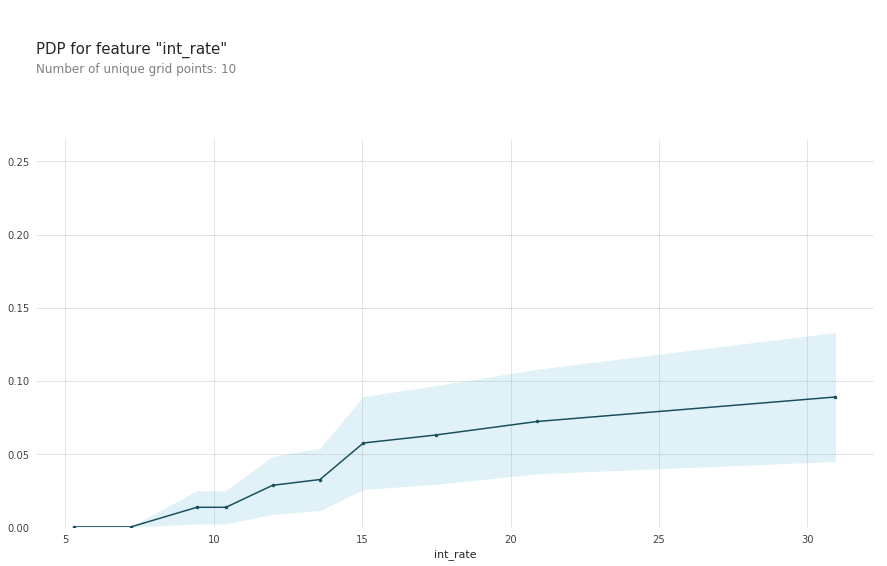

In [22]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='int_rate'
pdp_isolated = pdp_isolate(model=gb, dataset=X_val, model_features=X_val.columns, feature=feature)
pdp_plot(pdp_isolated, feature);

### Individual predictions

In [0]:
import numpy as np
y_pred = (y_pred_proba >= 0.5).astype(int)
confidence = np.abs(y_pred_proba - 0.5)
preds = pd.DataFrame({'y_val': y_val, 'y_pred': y_pred, 'y_pred_proba': y_pred_proba, 'confidence': confidence})

In [24]:
# True positives, with high confidence
preds[(y_val==1) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,confidence,y_pred,y_pred_proba,y_val
17575,0.303640,1,0.803640,1
36032,0.284028,1,0.784028,1
24134,0.275933,1,0.775933,1
13765,0.265269,1,0.765269,1
24768,0.258786,1,0.758786,1


In [27]:
data_for_prediction = X_val.loc[17575]
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [28]:
# True negatives, with high confidence
preds[(y_val==0) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()

,confidence,y_pred,y_pred_proba,y_val
29029,0.485079,0,0.014921,0
1778,0.482572,0,0.017428,0
23855,0.480766,0,0.019234,0
21604,0.480428,0,0.019572,0
32965,0.480246,0,0.019754,0


In [29]:
data_for_prediction = X_val.loc[1778]
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [0]:
# False positives, with high (mistaken) confidence
preds[(y_val==0) & (y_pred==1)].sort_values(by='confidence', ascending=False).head()

,y_val,y_pred,y_pred_proba,confidence
33542,0,1,0.893203,0.393203
9560,0,1,0.712540,0.212540
15711,0,1,0.698724,0.198724
11486,0,1,0.696137,0.196137
34640,0,1,0.688740,0.188740


In [30]:
data_for_prediction = X_val.loc[33542]
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [31]:
# False negatives, with high (mistaken) confidence
preds[(y_val==1) & (y_pred==0)].sort_values(by='confidence', ascending=False).head()

,confidence,y_pred,y_pred_proba,y_val
30492,0.478103,0,0.021897,1
22307,0.471715,0,0.028285,1
5743,0.470226,0,0.029774,1
23226,0.467684,0,0.032316,1
10300,0.463408,0,0.036592,1


In [32]:
data_for_prediction = X_val.loc[30492]
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [33]:
# Most uncertain predictions (least confidence)
preds.sort_values(by='confidence', ascending=True).head()

,confidence,y_pred,y_pred_proba,y_val
33095,0.000541,0,0.499459,0
25617,0.001673,0,0.498327,1
17698,0.001813,1,0.501813,1
15538,0.001889,1,0.501889,1
36197,0.004073,0,0.495927,0


In [34]:
data_for_prediction = X_val.loc[22527]
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)